In [1]:
import numpy as np
from typing import Dict, List
import anytree
import ot
import torch
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
import time
import seaborn as sns
import pandas as pd

import gwb as gwb
from gwb import GM as gm
from sklearn.datasets import fetch_openml
import gromovWassersteinAveraging as gwa
from sklearn.manifold import MDS

import os

In [2]:
def img2atomic(img):
    '''
    Creates a discrete measure from an image.
    '''
    assert img.ndim == 2, "img needs to be 2d array"
    x, y = img.shape
    pts = np.stack([grid.flatten() for grid in np.meshgrid(np.arange(x), y-np.arange(y))], axis=1)
    return pts[img.flatten() > 0], img.flatten()[img.flatten() > 0]

def compute_gwbl(Y,Xs):
    method = "cg"
    cr = "NWCR"
    #bary_NC = gm(g=CnBase,xi=pnBase,mode="gauge_only")
    Ps = gwb.tb(Y,Xs,method=method,cr=cr)[2]
    #bary = gwb.bary_from_tb(Xs,idxs,meas)
    #nodes = np.array([[idx2nodes[i][j] for j in idxs[:,i]] for i in range(n)],dtype=int).T  

    gwbl = gwb.gwb_loss(Y,Xs,Ps)
    return gwbl

In [3]:
def log_map(C0, C1, p, q):  
    opt_coup, log = ot.gromov.gromov_wasserstein(C0, C1, p, q, "square_loss",log=True)
    coup, C0, C1, p, q = gwa.split_cost_coupling_probabilities(opt_coup, C0, C1, p, q)
    perm = 1*(coup != 0)
    C1 = np.matmul(np.matmul(perm,C1),perm.T)
    vec = -C0 + C1 #[samir] this is the main step
    return C0, C1, p, q, vec, opt_coup

def CN_method(CList,pList,CBase,pBase,t,max_time):
    st = time.time()
    numC = len(CList)
    tangent_vectors = []
    
    for j in range(numC):
        CBase, C1, pBase, q, vec, opt_coup = log_map(CBase,CList[j],pBase,pList[j])
        tangent_vectors.append(vec)
        # this is the part which expands all the previously computed tangent vectors
        for k in range(j):
            bad_rows, row_indices, num_copies = gwa.find_bad_rows(opt_coup)
            tangent_vectors[k] = gwa.split_matrix_all_points(row_indices, num_copies, tangent_vectors[k])
            
            if k % 10 == 0 and (time.time() - st) + t > max_time:
                return CBase,pBase
            
    gradient = (1/float(numC))*sum(tangent_vectors)
    
    CBase = gwa.exp_map(CBase,gradient)
    
    return CBase, pBase

In [4]:
def one_iteration_gwb(Y,Xs,mode,t,max_time):
    N = len(Xs)
    if mode == "BB":
        st = time.time()
        idxs, meas, Ps, ref_idx = gwb.tb(Y,Xs,method="cg",cr="NWCR")        
        Y_new = gwb.bary_from_tb(Xs,idxs,meas)
        t = time.time() - st

    elif mode == "PCS":
        st = time.time()
        Ps = [ot.gromov.gromov_wasserstein(Xs[i].g, Y.g, Xs[i].xi, Y.xi, "square_loss") for i in range(N)]#**{"numItermaxEmd" : 500000}
        C = ot.gromov.update_square_loss(Y.xi, ot.unif(N), Ps, [X.g for X in Xs])
        t = time.time() - st
        
        Y_new = gm(mode="gauge_only",g = C, xi = Y.xi)
        
    elif mode == "PCSeps":
        st = time.time()
        Ps = [ot.gromov.entropic_gromov_wasserstein(Xs[i].g, Y.g, Xs[i].xi, Y.xi, "square_loss",epsilon = 1e-3) for i in range(N)]#**{"numItermaxEmd" : 500000}
        C = ot.gromov.update_square_loss(Y.xi, ot.unif(N), Ps, [X.g for X in Xs])
        t = time.time() - st
        
        Y_new = gm(mode="gauge_only",g = C, xi = Y.xi)
        
    elif mode == "CN":
        st = time.time()
        CBase,pBase = CN_method([X.g for X in Xs],[X.xi for X in Xs],Y.g,Y.xi,t,max_time)
        #C0, pBase, gradient = gwa.frechet_gradient([X.g for X in Xs],[X.xi for X in Xs],Y.g,Y.xi)#,np.infty)
        #CBase = gwa.exp_map(C0,gradient)
        t = time.time() - st
    
        Y_new = gm(mode="gauge_only",g = CBase,xi = pBase)
        
    return Y_new,compute_gwbl(Y_new,Xs),t

In [5]:
mnist_x,mnist_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False,parser="auto")
mnist_x = [x / np.sum(x) for x in mnist_x]

In [6]:
modes = ["BB","PCS","PCS2","CN","PCSeps","PCS2eps"]
L = 10
max_time = 5
N=3

gwbls2 = [dict(zip(modes, [[[] for l in range(L)] for _ in range(len(modes))])) for y0 in range(10)]
#its2 = [dict(zip(modes, [[[] for l in range(L)] for _ in range(len(modes))])) for y0 in range(10)]
Ys2 = [dict(zip(modes, [[[] for l in range(L)] for _ in range(len(modes))])) for y0 in range(10)]
times2 = [dict(zip(modes, [[[] for l in range(L)] for _ in range(len(modes))])) for y0 in range(10)]
Xs2 = [[[] for l in range(L)] for y0 in range(10)]

In [7]:
its2 = np.extract(True,np.load("./num_its.npy",allow_pickle=True))[0]

In [8]:
np.random.seed(0)

for y0 in trange(0,10):
    imgs = np.array(mnist_x)[np.where(mnist_y == str(y0))[0]]
    for l in range(L):
        #initialize gm-spaces
        idxs_imgs = np.random.choice(np.arange(len(imgs)),N,replace=False)
        Xs = []
        for i in range(N):
            pos, xi = img2atomic(imgs[idxs_imgs[i]].reshape((28,28)))
            X = gm(X=pos,xi=xi,mode="euclidean",gauge_mode="euclidean",normalize_gauge=True,squared=False)
            Xs.append(X)
        order = np.argsort([X.len for X in Xs])
        Xs = np.flip([Xs[i] for i in order])
        
        Xs2[y0][l] = Xs
        for k in range(len(modes)):
            mode = modes[k]
            #iterate
            if mode == "PCS2" or mode == "PCS2eps":
                bary_method = mode[:3] + mode[4:]
                gauss_points = ot.datasets.make_2D_samples_gauss(n = Ys2[y0]["BB"][l][-2].len, m =[0,0], sigma=1)
                Y = gm(X=gauss_points,mode="euclidean",gauge_mode="euclidean",normalize_gauge=True,squared=False)
            else:
                bary_method = mode
                Y = Xs[0]
            gwbl = compute_gwbl(Y,Xs)
            elapsed = 0
            gwbls = [gwbl]
            times = [elapsed]
            Ys = [Y]
            it = 0
            #while(elapsed <= max_time): #
            for it in range(its2[mode][y0][l]):
                Y,gwbl,t = one_iteration_gwb(Y,Xs,mode=bary_method,t=elapsed,max_time=max_time)
                elapsed += t
                times.append(elapsed)
                gwbls.append(gwbl)
                Ys.append(Y)

            gwbls2[y0][mode][l] = gwbls#[:-1]
            Ys2[y0][mode][l] = Ys#[:-1]
            times2[y0][mode][l] = times#[:-1]


 10%|████                                     | 1/10 [07:21<1:06:15, 441.75s/it]/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
100%|████████████████████████████████████████| 10/10 [1:14:35<00:00, 447.60s/it]


In [9]:
min_gwbls_PCS = np.concatenate([[np.min(gwbls2[y0]["PCS"][l]) for l in range(L)] for y0 in range(10)])
min_gwbls_BB = np.concatenate([[np.min(gwbls2[y0]["BB"][l]) for l in range(L)] for y0 in range(10)])
min_gwbls_CN = np.concatenate([[np.min(gwbls2[y0]["CN"][l]) for l in range(L)] for y0 in range(10)])
min_gwbls_PCS2 = np.concatenate([[np.min(gwbls2[y0]["PCS2"][l]) for l in range(L)] for y0 in range(10)])
min_gwbls_PCSeps = np.concatenate([[np.min(gwbls2[y0]["PCSeps"][l]) for l in range(L)] for y0 in range(10)])
min_gwbls_PCS2eps = np.concatenate([[np.min(gwbls2[y0]["PCS2eps"][l]) for l in range(L)] for y0 in range(10)])

df_PCS = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_PCS,"method":"PCS"})
df_BB = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_BB,"method":"BB"})
df_CN = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_CN,"method":"CN"})
df_PCS2 = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_PCS2,"method":"PCS2"})
df_PCSeps = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_PCSeps,"method":"PCSeps"})
df_PCS2eps = pd.DataFrame({"Class":np.arange(10*L),"Barycenter Loss":min_gwbls_PCS2eps,"method":"PCS2eps"})

df = pd.concat([df_PCS,df_PCS2,df_PCSeps,df_PCS2eps,df_CN,df_BB])


In [10]:
#NEW
for y0 in range(10):
    print("class: " + str(y0))
    print("-------------------")
    for mode in modes:
        tmp = df[((df.loc[:,"Class"]// 10) == y0) * df.loc[:,"method"] == mode].loc[:,"Barycenter Loss"]
        print("mean: " + str(tmp.mean())[:8] + " +- " + str(tmp.std())[:8] + " | mode: " + mode )

class: 0
-------------------
mean: 0.002893 +- 0.001145 | mode: BB
mean: 0.002878 +- 0.001315 | mode: PCS
mean: 0.023504 +- 0.019716 | mode: PCS2
mean: 0.003174 +- 0.001224 | mode: CN
mean: 0.005098 +- 0.002863 | mode: PCSeps
mean: 0.045850 +- 0.008058 | mode: PCS2eps
class: 1
-------------------
mean: 0.000682 +- 0.000339 | mode: BB
mean: 0.000709 +- 0.000309 | mode: PCS
mean: 0.010218 +- 0.013898 | mode: PCS2
mean: 0.000673 +- 0.000332 | mode: CN
mean: 0.001219 +- 0.000576 | mode: PCSeps
mean: 0.032205 +- 0.004116 | mode: PCS2eps
class: 2
-------------------
mean: 0.005077 +- 0.001934 | mode: BB
mean: 0.004453 +- 0.002002 | mode: PCS
mean: 0.031961 +- 0.017687 | mode: PCS2
mean: 0.006641 +- 0.002164 | mode: CN
mean: 0.007801 +- 0.003481 | mode: PCSeps
mean: 0.037392 +- 0.007488 | mode: PCS2eps
class: 3
-------------------
mean: 0.003441 +- 0.001200 | mode: BB
mean: 0.003238 +- 0.001269 | mode: PCS
mean: 0.037817 +- 0.013353 | mode: PCS2
mean: 0.003698 +- 0.001160 | mode: CN
mean: 0.0

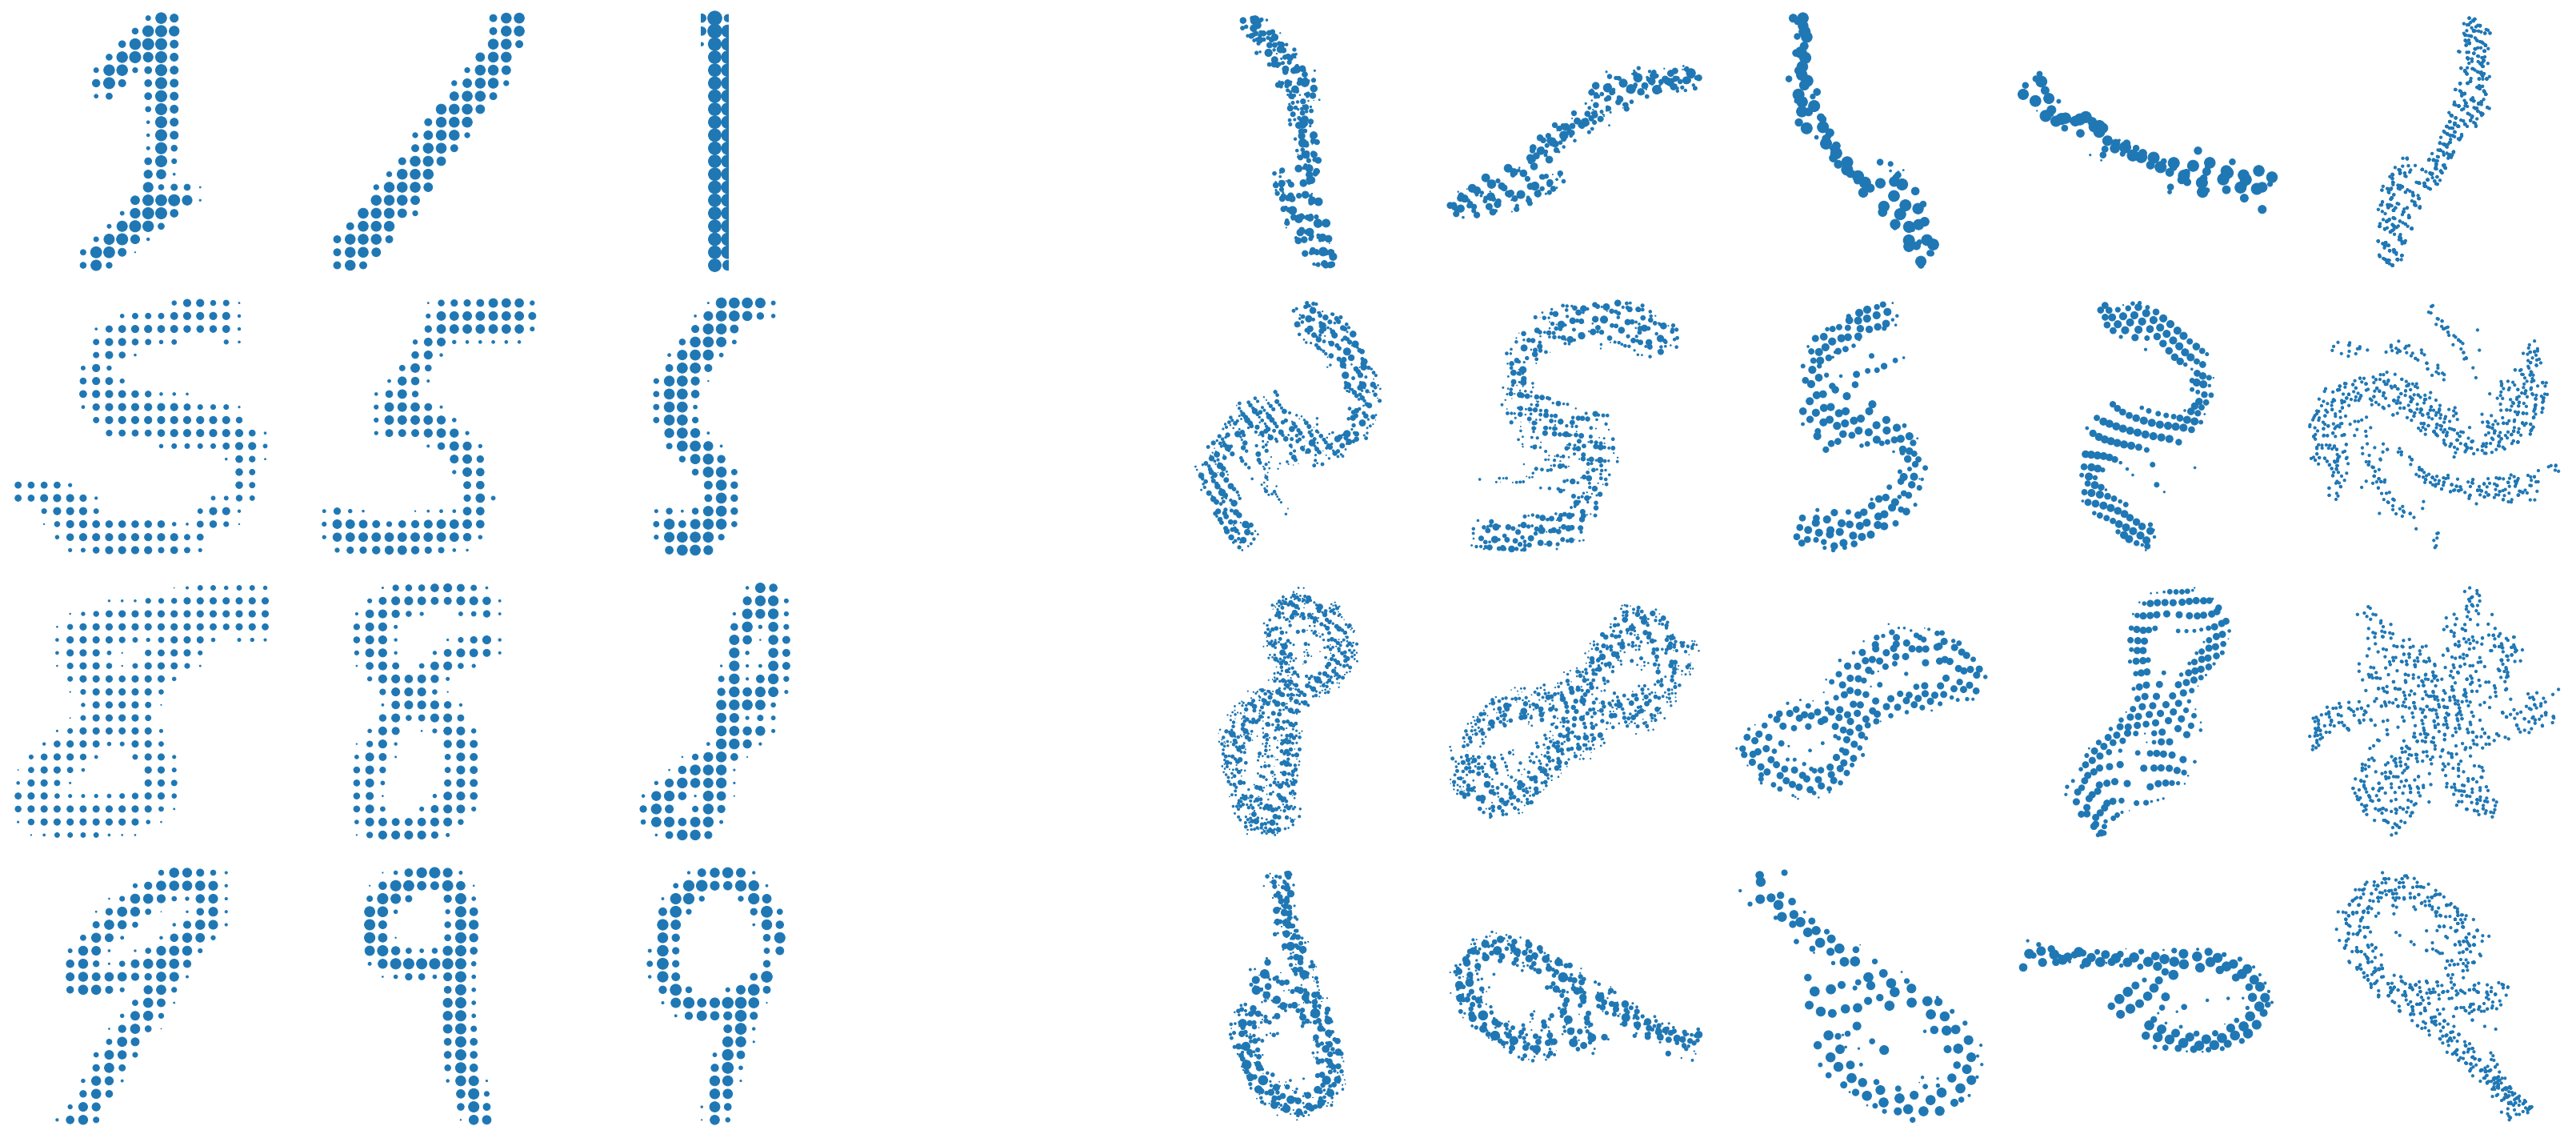

In [144]:
np.random.seed(0)
ls = [0,6,7,9]#[2,4,4,3,0,6,8,7,8,9]
fig,ax = plt.subplots(4,9,figsize=(5*9,5*4))
for it,y0 in enumerate([1,5,8,9]):
    l = ls[it]
    for j in range(N):
        ax[it,j].scatter(Xs2[y0][l][j].X[:,0],Xs2[y0][l][j].X[:,1],s= 10000 * Xs2[y0][l][j].xi)
        ax[it,j].set_xticks([])
        ax[it,j].set_yticks([])
        ax[it,j].set_aspect('equal', 'box')
        ax[it,j].axis("off")
    j = 1
    ax[it,3].axis("off")
    for mode in ["BB","CN","PCS","PCSeps","PCS2"]:
        Y = Ys2[y0][mode][l][np.argmin(gwbls2[y0][mode][l])]
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0,normalized_stress="auto")
        embedding = mds.fit_transform(Y.g)
        ax[it,j+N].scatter(embedding[:,0],embedding[:,1],s=10000*Y.xi)
        ax[it,j+N].set_xticks([])
        ax[it,j+N].set_yticks([])
        ax[it,j+N].axis("off")
        ax[it,j+N].set_aspect('equal', 'box')
        j += 1
plt.tight_layout()
plt.show()

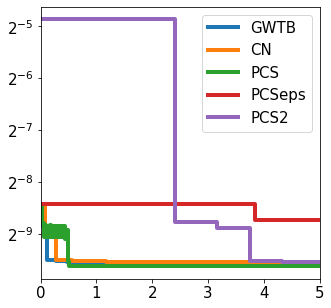

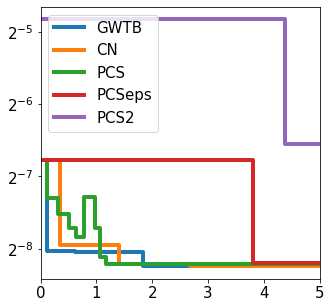

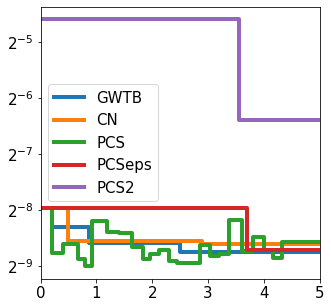

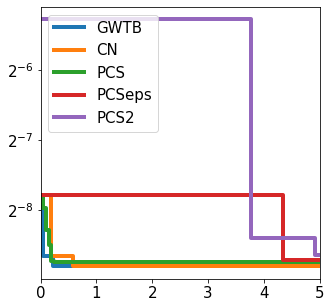

In [135]:
plt.rcParams.update({'font.size': 15})

for it,y0 in enumerate([1,5,8,9]):
    l = ls[it]
    fig, ax = plt.subplots(figsize=(5,5))#,sharey=True)
    ax.set_xlim(0,5)
    ax.set_xticks(np.arange(6))
    plt.yscale('log',base=2)
    for j,mode in enumerate(["BB","CN","PCS","PCSeps","PCS2"]):
        if mode == "BB":
            label = "GWTB"
        else:
            label = mode
        ax.step(np.concatenate([times2[y0][mode][l],[5]]),np.concatenate([gwbls2[y0][mode][l],[gwbls2[y0][mode][l][-1]]]),where="post",label=label,linewidth=4)
    plt.legend()
    plt.show()